In [0]:
import tensorflow as tf

### Getting the list of devices

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5896570867293682093
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281989632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3316875706752604150
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Logging the device during execution

In [3]:
matrix_1 = tf.constant([[3, 5]])
matrix_2 = tf.constant([[2],[4]])

product = tf.matmul(matrix_1, matrix_2)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
  print(sess.run(product))

[[26]]


### CPU vs GPU

In [4]:
import time

device_with_times = {
    "/device:CPU:0":[],
    "/device:GPU:0":[]
}
matrix_sizes = range(500,5000,500)

for size in matrix_sizes:
    for device_name in device_with_times.keys():
        shape = (size,size)
        with tf.device(device_name):
            matrix_1 = tf.random_uniform(shape=shape)
            matrix_2 = tf.random_uniform(shape=shape)
            product = tf.matmul(matrix_1, matrix_2)

        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
                start_time = time.time()
                result = sess.run(product)
                time_taken = time.time() - start_time
                device_with_times[device_name].append(time_taken)

cpu_times = device_with_times["/device:CPU:0"]
gpu_times = device_with_times["/device:GPU:0"]
print("CPU:", cpu_times)
print("GPU:", gpu_times)

CPU: [0.016841650009155273, 0.05473446846008301, 0.12443780899047852, 0.2377021312713623, 0.35091328620910645, 0.550788164138794, 1.0631613731384277, 2.1046807765960693, 2.929041624069214]
GPU: [0.17808175086975098, 0.012151479721069336, 0.022293806076049805, 0.01881551742553711, 0.033457279205322266, 0.04677152633666992, 0.07753682136535645, 0.11061835289001465, 0.12297892570495605]


### Plotting the results

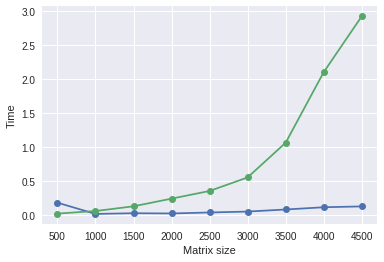

In [5]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(matrix_sizes[:len(gpu_times)], gpu_times, 'o-')
plt.plot(matrix_sizes[:len(cpu_times)], cpu_times, 'o-')
plt.ylabel('Time')
plt.xlabel('Matrix size')
plt.show()

###  Model paralellism

In [6]:
matrix_1 = tf.random_uniform([2, 3])
matrix_2 = tf.random_uniform([3, 3])

products = []

with tf.device('/device:GPU:0'):
    products.append(tf.matmul(matrix_1, matrix_2))

with tf.device('/device:GPU:1'):
    products.append(tf.matmul(matrix_1, matrix_2))

with tf.device('/device:CPU:0'):
    sum_of_products = tf.add_n(products)

with tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)) as sess:
  init = tf.global_variables_initializer()
  sess.run(init)

  print(sess.run(sum_of_products))

[[0.9370578  2.6723866  0.5972967 ]
 [0.86552775 2.5983357  0.5942787 ]]


### Data Paralellism

In [7]:
available_devices = ["/device:GPU:0", "/device:GPU:1"]
num_devices = len(available_devices)

matrices_x = tf.random_uniform([num_devices, 2, 3])
matrices_y = tf.random_uniform([num_devices, 3, 3])

products = []

# Multiple towers
# Tower i is responsible for batch data i
for i, d in enumerate(available_devices):
    with tf.device(d):
        products.append(tf.matmul(matrices_x[i], matrices_y[i])) 

with tf.device("/device:CPU:0"):
    sum_of_products = tf.add_n(products)

with tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)) as sess:
  init = tf.global_variables_initializer()
  sess.run(init)

  print(sess.run(sum_of_products))

[[2.091125  2.1728518 1.9910071]
 [2.458892  3.0698667 2.416468 ]]
